# Libraries

Import libraries, set random seed, define rainy threshold

In [1]:
import os

import numpy as np
import pandas as pd
from math import floor, ceil

import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import tensorflow as tf

print('All packages imported.')

All packages imported.


In [2]:
# Random seed for reproducibility

seed = 42
print(f'Random seed set as {seed}.')

Random seed set as 42.


In [3]:
# Set threshold of rainy events
classification = True

prec_threshold = 0
print(f'Threshold of rainy event is {prec_threshold} mm/hr')
print('Classification' if classification else 'Regression')

Threshold of rainy event is 0 mm/hr
Classification


# Data Import

In [4]:
def get_file_path(file_name):
    CURRENT_DIR = os.getcwd()
    DATA_DIR = f'{CURRENT_DIR}/../../../data/stage-1_cleaned'
    FILE_PATH = f'{DATA_DIR}/{file_name}'
    return FILE_PATH


def import_DS(FILE_PATH):
    return xr.open_dataset(FILE_PATH)

def DS_dropna(DS):
    return DS.dropna(dim='time')

In [5]:
FILE_PATH = get_file_path(file_name='merged_dropped.cdf')
DS_raw = import_DS(FILE_PATH)
DS_raw

<xarray.Dataset>
Dimensions:                    (p: 37, time: 4759)
Coordinates:
  * time                       (time) datetime64[ns] 1997-08-28T04:30:00 ... 2010-08-25T23:30:00
  * p                          (p) float32 1000.0 975.0 950.0 ... 125.0 100.0
Data variables:
    prec_sfc_next              (time) float32 ...
    T_sfc                      (time) float32 ...
    p_sfc                      (time) float32 ...
    rh_sfc                     (time) float32 ...
    u_sfc                      (time) float32 ...
    v_sfc                      (time) float32 ...
    prec_sfc                   (time) float32 ...
    T_p                        (time, p) float32 ...
    rh_p                       (time, p) float32 ...
    u_p                        (time, p) float32 ...
    v_p                        (time, p) float32 ...
    down_short_diffuse_hemisp  (time) float64 ...

In [6]:
DS = DS_dropna(DS_raw)
DS

<xarray.Dataset>
Dimensions:                    (p: 37, time: 4759)
Coordinates:
  * time                       (time) datetime64[ns] 1997-08-28T04:30:00 ... 2010-08-25T23:30:00
  * p                          (p) float32 1000.0 975.0 950.0 ... 125.0 100.0
Data variables:
    prec_sfc_next              (time) float32 0.04966664 0.04999997 ... 0.0 0.0
    T_sfc                      (time) float32 300.92734 301.03537 ... 299.10202
    p_sfc                      (time) float32 1008.7901 ... 1010.95233
    rh_sfc                     (time) float32 80.57 72.501755 ... 87.67273
    u_sfc                      (time) float32 -2.7884665 ... -1.1461726
    v_sfc                      (time) float32 4.551383 5.972651 ... 2.0953407
    prec_sfc                   (time) float32 0.047666643 ... 0.44877273
    T_p                        (time, p) float32 299.9794 297.85 ... 195.81091
    rh_p                       (time, p) float32 72.117645 ... 21.037518
    u_p                        (time, p) float3

# Data Pre-processing

In [7]:
str_y = 'prec_sfc_next'
str_x_scalar = ['T_sfc', 'p_sfc', 'rh_sfc', 'u_sfc', 'v_sfc', 'prec_sfc', 'down_short_diffuse_hemisp']
str_x_1d = ['T_p', 'rh_p', 'u_p', 'v_p']
plev = DS['p'].values.astype(float)  # array of pressure level

def extract(DS, str_y=str_y, str_x_scalar=str_x_scalar):
    return DS[str_y].to_dataframe().values, DS[str_x_scalar].to_dataframe().values


def merge_channels(DS, str_x_1d=str_x_1d):
    channels = [DS[str_x_1d[i]].to_dataframe().unstack(level=-1)
                for i in range(0, len(str_x_1d))]
    X_conv = np.expand_dims(channels[0].values, axis=2)

    for channel in channels[1:]:
        channel = np.expand_dims(channel.values, axis=2)
        X_conv = np.append(X_conv, channel, axis=2)

    return X_conv

In [8]:
y, X_scalar = extract(DS)
print(y.shape)
print(X_scalar.shape)

(4759, 1)
(4759, 7)


In [9]:
X_conv = merge_channels(DS)
X_conv.shape

(4759, 37, 4)

In [12]:
binary = y > prec_threshold
print('1 class ratio= {:.2%}'.format(binary.mean()))

1 class ratio= 48.60%


# Data Standardization

In [10]:
def split(binary, y, X_scalar, X_conv, train_size=0.7, seed=seed):
    from sklearn.model_selection import train_test_split
    train_binary, test_binary, train_y, test_y, train_X_scalar, test_X_scalar, train_X_conv, test_X_conv = train_test_split(binary, y, X_scalar, X_conv,
                                                                                                                            train_size=train_size,
                                                                                                                            random_state=seed,
                                                                                                                            shuffle=True,
                                                                                                                            stratify=None)
    return train_binary, test_binary, train_y, test_y, train_X_scalar, test_X_scalar, train_X_conv, test_X_conv


def standardize(train, test):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    return train, test, scaler


def standardize_3d(train, test):
    from sklearn.preprocessing import StandardScaler
    scalers = {}
    for i in range(train.shape[2]):
        scalers[i] = StandardScaler()
        train[:, :, i] = scalers[i].fit_transform(train[:, :, i])

    for i in range(test.shape[2]):
        test[:, :, i] = scalers[i].transform(test[:, :, i])

    return train, test, scalers

In [13]:
# train-test split
train_binary, test_binary, train_y, test_y, train_X_scalar, test_X_scalar, train_X_conv, test_X_conv = split(
    binary, y, X_scalar, X_conv)

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
# standardize
train_y, test_y, scaler_y = standardize(train_y, test_y)
train_X_scalar, test_X_scalar, scaler_X_scalar = standardize(train_X_scalar, test_X_scalar)
train_X_conv, test_X_conv, scalers_X_conv = standardize_3d(train_X_conv, test_X_conv)

# Neural Network Training

In [15]:
from keras.models import Model
from keras.layers import Activation, BatchNormalization, Conv1D, Dense, Dropout, MaxPooling1D
from keras.layers import concatenate, Flatten, Input
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import regularizers

Using TensorFlow backend.


In [26]:
final_activation, loss_metric, show_metric, labels = [
    'sigmoid', 'binary_crossentropy', ['accuracy'], train_binary] if classification else ['relu', 'mean_squared_error', None, train_y]


# Input placeholders
input_conv = Input(shape=train_X_conv.shape[1:], name='column_input')
input_scalar = Input(shape=(train_X_scalar.shape[1],), name='surface_input')

# Hidden layers
conv_1 = Conv1D(8, kernel_size=6)(input_conv)
bn_1 = BatchNormalization()(conv_1)
pool_1 = MaxPooling1D(pool_size=4)(bn_1)
act_1 = Activation('relu')(pool_1)

conv_2 = Conv1D(4, kernel_size=4)(act_1)
bn_2 = BatchNormalization()(conv_2)
pool_2 = MaxPooling1D(pool_size=5)(bn_2)
act_2 = Activation('relu')(pool_2)

flatten_2 = Flatten()(act_2)

layer = concatenate([flatten_2, input_scalar])
#layer = Dense(4, activation='relu')(layer)

output = Dense(1,
               kernel_regularizer=regularizers.l2(0.02),
               activation=final_activation,
               name='output')(layer)

# 1. Initialize
model = Model(inputs=[input_conv, input_scalar], outputs=output)
plot_model(model, show_shapes=True, to_file='model.png')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
column_input (InputLayer)       (None, 37, 4)        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 32, 8)        200         column_input[0][0]               
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 32, 8)        32          conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 8, 8)         0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
activation

In [27]:
# 2. Compile
model.compile(optimizer=Adam(),
              loss=loss_metric,
              metrics=show_metric)

In [28]:
# 3. Train
model.fit([train_X_conv, train_X_scalar], labels,
          epochs=5000,
          verbose=2)

Epoch 1/5000
 - 1s - loss: 0.8523 - acc: 0.5152
Epoch 2/5000
 - 0s - loss: 0.7555 - acc: 0.5530
Epoch 3/5000
 - 0s - loss: 0.7200 - acc: 0.5725
Epoch 4/5000
 - 0s - loss: 0.7026 - acc: 0.5839
Epoch 5/5000
 - 0s - loss: 0.6885 - acc: 0.5887
Epoch 6/5000
 - 0s - loss: 0.6778 - acc: 0.5941
Epoch 7/5000
 - 0s - loss: 0.6704 - acc: 0.6067
Epoch 8/5000
 - 0s - loss: 0.6660 - acc: 0.6112
Epoch 9/5000
 - 0s - loss: 0.6587 - acc: 0.6199
Epoch 10/5000
 - 0s - loss: 0.6556 - acc: 0.6223
Epoch 11/5000
 - 0s - loss: 0.6474 - acc: 0.6409
Epoch 12/5000
 - 0s - loss: 0.6473 - acc: 0.6352
Epoch 13/5000
 - 0s - loss: 0.6409 - acc: 0.6509
Epoch 14/5000
 - 0s - loss: 0.6390 - acc: 0.6503
Epoch 15/5000
 - 0s - loss: 0.6351 - acc: 0.6512
Epoch 16/5000
 - 0s - loss: 0.6313 - acc: 0.6647
Epoch 17/5000
 - 0s - loss: 0.6299 - acc: 0.6557
Epoch 18/5000
 - 0s - loss: 0.6305 - acc: 0.6605
Epoch 19/5000
 - 0s - loss: 0.6270 - acc: 0.6731
Epoch 20/5000
 - 0s - loss: 0.6268 - acc: 0.6707
Epoch 21/5000
 - 0s - loss: 0

 - 0s - loss: 0.5683 - acc: 0.7256
Epoch 168/5000
 - 0s - loss: 0.5722 - acc: 0.7292
Epoch 169/5000
 - 0s - loss: 0.5692 - acc: 0.7286
Epoch 170/5000
 - 0s - loss: 0.5630 - acc: 0.7301
Epoch 171/5000
 - 0s - loss: 0.5673 - acc: 0.7271
Epoch 172/5000
 - 0s - loss: 0.5654 - acc: 0.7226
Epoch 173/5000
 - 0s - loss: 0.5686 - acc: 0.7265
Epoch 174/5000
 - 0s - loss: 0.5648 - acc: 0.7304
Epoch 175/5000
 - 0s - loss: 0.5666 - acc: 0.7226
Epoch 176/5000
 - 0s - loss: 0.5639 - acc: 0.7349
Epoch 177/5000
 - 0s - loss: 0.5691 - acc: 0.7268
Epoch 178/5000
 - 0s - loss: 0.5629 - acc: 0.7316
Epoch 179/5000
 - 0s - loss: 0.5671 - acc: 0.7250
Epoch 180/5000
 - 0s - loss: 0.5688 - acc: 0.7280
Epoch 181/5000
 - 0s - loss: 0.5624 - acc: 0.7289
Epoch 182/5000
 - 0s - loss: 0.5644 - acc: 0.7280
Epoch 183/5000
 - 0s - loss: 0.5636 - acc: 0.7334
Epoch 184/5000
 - 0s - loss: 0.5653 - acc: 0.7271
Epoch 185/5000
 - 0s - loss: 0.5638 - acc: 0.7316
Epoch 186/5000
 - 0s - loss: 0.5644 - acc: 0.7274
Epoch 187/5000


 - 0s - loss: 0.5455 - acc: 0.7433
Epoch 332/5000
 - 0s - loss: 0.5480 - acc: 0.7343
Epoch 333/5000
 - 0s - loss: 0.5474 - acc: 0.7409
Epoch 334/5000
 - 0s - loss: 0.5486 - acc: 0.7331
Epoch 335/5000
 - 0s - loss: 0.5462 - acc: 0.7424
Epoch 336/5000
 - 0s - loss: 0.5461 - acc: 0.7343
Epoch 337/5000
 - 0s - loss: 0.5476 - acc: 0.7379
Epoch 338/5000
 - 0s - loss: 0.5457 - acc: 0.7424
Epoch 339/5000
 - 0s - loss: 0.5508 - acc: 0.7322
Epoch 340/5000
 - 0s - loss: 0.5481 - acc: 0.7385
Epoch 341/5000
 - 0s - loss: 0.5465 - acc: 0.7349
Epoch 342/5000
 - 0s - loss: 0.5474 - acc: 0.7391
Epoch 343/5000
 - 0s - loss: 0.5497 - acc: 0.7313
Epoch 344/5000
 - 0s - loss: 0.5469 - acc: 0.7334
Epoch 345/5000
 - 0s - loss: 0.5434 - acc: 0.7403
Epoch 346/5000
 - 0s - loss: 0.5476 - acc: 0.7421
Epoch 347/5000
 - 0s - loss: 0.5476 - acc: 0.7361
Epoch 348/5000
 - 0s - loss: 0.5459 - acc: 0.7433
Epoch 349/5000
 - 0s - loss: 0.5451 - acc: 0.7418
Epoch 350/5000
 - 0s - loss: 0.5498 - acc: 0.7364
Epoch 351/5000


 - 0s - loss: 0.5380 - acc: 0.7403
Epoch 496/5000
 - 0s - loss: 0.5429 - acc: 0.7439
Epoch 497/5000
 - 0s - loss: 0.5382 - acc: 0.7475
Epoch 498/5000
 - 0s - loss: 0.5348 - acc: 0.7463
Epoch 499/5000
 - 0s - loss: 0.5387 - acc: 0.7451
Epoch 500/5000
 - 0s - loss: 0.5384 - acc: 0.7460
Epoch 501/5000
 - 0s - loss: 0.5369 - acc: 0.7472
Epoch 502/5000
 - 0s - loss: 0.5372 - acc: 0.7475
Epoch 503/5000
 - 0s - loss: 0.5399 - acc: 0.7520
Epoch 504/5000
 - 0s - loss: 0.5408 - acc: 0.7382
Epoch 505/5000
 - 0s - loss: 0.5359 - acc: 0.7451
Epoch 506/5000
 - 0s - loss: 0.5389 - acc: 0.7436
Epoch 507/5000
 - 0s - loss: 0.5360 - acc: 0.7445
Epoch 508/5000
 - 0s - loss: 0.5392 - acc: 0.7424
Epoch 509/5000
 - 0s - loss: 0.5418 - acc: 0.7391
Epoch 510/5000
 - 0s - loss: 0.5318 - acc: 0.7496
Epoch 511/5000
 - 0s - loss: 0.5447 - acc: 0.7331
Epoch 512/5000
 - 0s - loss: 0.5373 - acc: 0.7457
Epoch 513/5000
 - 0s - loss: 0.5413 - acc: 0.7403
Epoch 514/5000
 - 0s - loss: 0.5383 - acc: 0.7409
Epoch 515/5000


 - 0s - loss: 0.5330 - acc: 0.7484
Epoch 660/5000
 - 0s - loss: 0.5345 - acc: 0.7550
Epoch 661/5000
 - 0s - loss: 0.5309 - acc: 0.7517
Epoch 662/5000
 - 0s - loss: 0.5355 - acc: 0.7466
Epoch 663/5000
 - 0s - loss: 0.5358 - acc: 0.7427
Epoch 664/5000
 - 0s - loss: 0.5341 - acc: 0.7427
Epoch 665/5000
 - 0s - loss: 0.5388 - acc: 0.7391
Epoch 666/5000
 - 0s - loss: 0.5363 - acc: 0.7424
Epoch 667/5000
 - 0s - loss: 0.5339 - acc: 0.7505
Epoch 668/5000
 - 0s - loss: 0.5331 - acc: 0.7493
Epoch 669/5000
 - 0s - loss: 0.5308 - acc: 0.7505
Epoch 670/5000
 - 0s - loss: 0.5317 - acc: 0.7571
Epoch 671/5000
 - 0s - loss: 0.5324 - acc: 0.7508
Epoch 672/5000
 - 0s - loss: 0.5304 - acc: 0.7469
Epoch 673/5000
 - 0s - loss: 0.5365 - acc: 0.7508
Epoch 674/5000
 - 0s - loss: 0.5333 - acc: 0.7421
Epoch 675/5000
 - 0s - loss: 0.5319 - acc: 0.7505
Epoch 676/5000
 - 0s - loss: 0.5357 - acc: 0.7421
Epoch 677/5000
 - 0s - loss: 0.5342 - acc: 0.7484
Epoch 678/5000
 - 0s - loss: 0.5332 - acc: 0.7490
Epoch 679/5000


 - 0s - loss: 0.5295 - acc: 0.7544
Epoch 824/5000
 - 0s - loss: 0.5347 - acc: 0.7427
Epoch 825/5000
 - 0s - loss: 0.5339 - acc: 0.7445
Epoch 826/5000
 - 0s - loss: 0.5309 - acc: 0.7448
Epoch 827/5000
 - 0s - loss: 0.5303 - acc: 0.7427
Epoch 828/5000
 - 0s - loss: 0.5283 - acc: 0.7517
Epoch 829/5000
 - 0s - loss: 0.5335 - acc: 0.7454
Epoch 830/5000
 - 0s - loss: 0.5258 - acc: 0.7586
Epoch 831/5000
 - 0s - loss: 0.5266 - acc: 0.7502
Epoch 832/5000
 - 0s - loss: 0.5315 - acc: 0.7472
Epoch 833/5000
 - 0s - loss: 0.5295 - acc: 0.7466
Epoch 834/5000
 - 0s - loss: 0.5322 - acc: 0.7415
Epoch 835/5000
 - 0s - loss: 0.5294 - acc: 0.7544
Epoch 836/5000
 - 0s - loss: 0.5331 - acc: 0.7421
Epoch 837/5000
 - 0s - loss: 0.5247 - acc: 0.7574
Epoch 838/5000
 - 0s - loss: 0.5284 - acc: 0.7478
Epoch 839/5000
 - 0s - loss: 0.5284 - acc: 0.7478
Epoch 840/5000
 - 0s - loss: 0.5319 - acc: 0.7553
Epoch 841/5000
 - 0s - loss: 0.5315 - acc: 0.7559
Epoch 842/5000
 - 0s - loss: 0.5289 - acc: 0.7457
Epoch 843/5000


 - 0s - loss: 0.5290 - acc: 0.7424
Epoch 988/5000
 - 0s - loss: 0.5322 - acc: 0.7484
Epoch 989/5000
 - 0s - loss: 0.5263 - acc: 0.7502
Epoch 990/5000
 - 0s - loss: 0.5240 - acc: 0.7421
Epoch 991/5000
 - 0s - loss: 0.5278 - acc: 0.7430
Epoch 992/5000
 - 0s - loss: 0.5265 - acc: 0.7448
Epoch 993/5000
 - 0s - loss: 0.5237 - acc: 0.7544
Epoch 994/5000
 - 0s - loss: 0.5266 - acc: 0.7457
Epoch 995/5000
 - 0s - loss: 0.5268 - acc: 0.7469
Epoch 996/5000
 - 0s - loss: 0.5263 - acc: 0.7469
Epoch 997/5000
 - 0s - loss: 0.5259 - acc: 0.7460
Epoch 998/5000
 - 0s - loss: 0.5304 - acc: 0.7451
Epoch 999/5000
 - 0s - loss: 0.5279 - acc: 0.7520
Epoch 1000/5000
 - 0s - loss: 0.5276 - acc: 0.7466
Epoch 1001/5000
 - 0s - loss: 0.5288 - acc: 0.7451
Epoch 1002/5000
 - 0s - loss: 0.5270 - acc: 0.7436
Epoch 1003/5000
 - 0s - loss: 0.5283 - acc: 0.7469
Epoch 1004/5000
 - 0s - loss: 0.5274 - acc: 0.7478
Epoch 1005/5000
 - 0s - loss: 0.5233 - acc: 0.7496
Epoch 1006/5000
 - 0s - loss: 0.5290 - acc: 0.7430
Epoch 10

 - 0s - loss: 0.5260 - acc: 0.7475
Epoch 1149/5000
 - 0s - loss: 0.5207 - acc: 0.7409
Epoch 1150/5000
 - 0s - loss: 0.5281 - acc: 0.7400
Epoch 1151/5000
 - 0s - loss: 0.5234 - acc: 0.7463
Epoch 1152/5000
 - 0s - loss: 0.5202 - acc: 0.7562
Epoch 1153/5000
 - 0s - loss: 0.5189 - acc: 0.7511
Epoch 1154/5000
 - 0s - loss: 0.5243 - acc: 0.7442
Epoch 1155/5000
 - 0s - loss: 0.5220 - acc: 0.7439
Epoch 1156/5000
 - 0s - loss: 0.5214 - acc: 0.7496
Epoch 1157/5000
 - 0s - loss: 0.5248 - acc: 0.7442
Epoch 1158/5000
 - 0s - loss: 0.5249 - acc: 0.7463
Epoch 1159/5000
 - 0s - loss: 0.5217 - acc: 0.7547
Epoch 1160/5000
 - 0s - loss: 0.5216 - acc: 0.7463
Epoch 1161/5000
 - 0s - loss: 0.5265 - acc: 0.7415
Epoch 1162/5000
 - 0s - loss: 0.5196 - acc: 0.7511
Epoch 1163/5000
 - 0s - loss: 0.5258 - acc: 0.7394
Epoch 1164/5000
 - 0s - loss: 0.5223 - acc: 0.7469
Epoch 1165/5000
 - 0s - loss: 0.5198 - acc: 0.7490
Epoch 1166/5000
 - 0s - loss: 0.5267 - acc: 0.7454
Epoch 1167/5000
 - 0s - loss: 0.5227 - acc: 0.7

Epoch 1309/5000
 - 0s - loss: 0.5274 - acc: 0.7466
Epoch 1310/5000
 - 0s - loss: 0.5225 - acc: 0.7427
Epoch 1311/5000
 - 0s - loss: 0.5241 - acc: 0.7511
Epoch 1312/5000
 - 0s - loss: 0.5221 - acc: 0.7511
Epoch 1313/5000
 - 0s - loss: 0.5208 - acc: 0.7490
Epoch 1314/5000
 - 0s - loss: 0.5206 - acc: 0.7466
Epoch 1315/5000
 - 0s - loss: 0.5218 - acc: 0.7496
Epoch 1316/5000
 - 0s - loss: 0.5202 - acc: 0.7436
Epoch 1317/5000
 - 0s - loss: 0.5232 - acc: 0.7427
Epoch 1318/5000
 - 0s - loss: 0.5222 - acc: 0.7457
Epoch 1319/5000
 - 0s - loss: 0.5191 - acc: 0.7502
Epoch 1320/5000
 - 0s - loss: 0.5230 - acc: 0.7466
Epoch 1321/5000
 - 0s - loss: 0.5171 - acc: 0.7538
Epoch 1322/5000
 - 0s - loss: 0.5149 - acc: 0.7478
Epoch 1323/5000
 - 0s - loss: 0.5240 - acc: 0.7526
Epoch 1324/5000
 - 0s - loss: 0.5232 - acc: 0.7541
Epoch 1325/5000
 - 0s - loss: 0.5247 - acc: 0.7424
Epoch 1326/5000
 - 0s - loss: 0.5244 - acc: 0.7478
Epoch 1327/5000
 - 0s - loss: 0.5252 - acc: 0.7427
Epoch 1328/5000
 - 0s - loss: 0

Epoch 1470/5000
 - 0s - loss: 0.5229 - acc: 0.7466
Epoch 1471/5000
 - 0s - loss: 0.5204 - acc: 0.7457
Epoch 1472/5000
 - 0s - loss: 0.5190 - acc: 0.7529
Epoch 1473/5000
 - 0s - loss: 0.5213 - acc: 0.7478
Epoch 1474/5000
 - 0s - loss: 0.5170 - acc: 0.7547
Epoch 1475/5000
 - 0s - loss: 0.5162 - acc: 0.7478
Epoch 1476/5000
 - 0s - loss: 0.5176 - acc: 0.7460
Epoch 1477/5000
 - 0s - loss: 0.5193 - acc: 0.7436
Epoch 1478/5000
 - 0s - loss: 0.5227 - acc: 0.7376
Epoch 1479/5000
 - 0s - loss: 0.5205 - acc: 0.7478
Epoch 1480/5000
 - 0s - loss: 0.5250 - acc: 0.7430
Epoch 1481/5000
 - 0s - loss: 0.5172 - acc: 0.7502
Epoch 1482/5000
 - 0s - loss: 0.5216 - acc: 0.7544
Epoch 1483/5000
 - 0s - loss: 0.5166 - acc: 0.7463
Epoch 1484/5000
 - 0s - loss: 0.5179 - acc: 0.7433
Epoch 1485/5000
 - 0s - loss: 0.5232 - acc: 0.7493
Epoch 1486/5000
 - 0s - loss: 0.5207 - acc: 0.7466
Epoch 1487/5000
 - 0s - loss: 0.5165 - acc: 0.7499
Epoch 1488/5000
 - 0s - loss: 0.5213 - acc: 0.7499
Epoch 1489/5000
 - 0s - loss: 0

Epoch 1631/5000
 - 0s - loss: 0.5195 - acc: 0.7403
Epoch 1632/5000
 - 0s - loss: 0.5143 - acc: 0.7490
Epoch 1633/5000
 - 0s - loss: 0.5148 - acc: 0.7544
Epoch 1634/5000
 - 0s - loss: 0.5173 - acc: 0.7472
Epoch 1635/5000
 - 0s - loss: 0.5199 - acc: 0.7445
Epoch 1636/5000
 - 0s - loss: 0.5167 - acc: 0.7520
Epoch 1637/5000
 - 0s - loss: 0.5173 - acc: 0.7418
Epoch 1638/5000
 - 0s - loss: 0.5170 - acc: 0.7535
Epoch 1639/5000
 - 0s - loss: 0.5208 - acc: 0.7484
Epoch 1640/5000
 - 0s - loss: 0.5191 - acc: 0.7484
Epoch 1641/5000
 - 0s - loss: 0.5183 - acc: 0.7427
Epoch 1642/5000
 - 0s - loss: 0.5189 - acc: 0.7424
Epoch 1643/5000
 - 0s - loss: 0.5208 - acc: 0.7472
Epoch 1644/5000
 - 0s - loss: 0.5231 - acc: 0.7472
Epoch 1645/5000
 - 0s - loss: 0.5166 - acc: 0.7517
Epoch 1646/5000
 - 0s - loss: 0.5214 - acc: 0.7535
Epoch 1647/5000
 - 0s - loss: 0.5169 - acc: 0.7454
Epoch 1648/5000
 - 0s - loss: 0.5166 - acc: 0.7469
Epoch 1649/5000
 - 0s - loss: 0.5219 - acc: 0.7418
Epoch 1650/5000
 - 0s - loss: 0

Epoch 1792/5000
 - 0s - loss: 0.5187 - acc: 0.7490
Epoch 1793/5000
 - 0s - loss: 0.5183 - acc: 0.7478
Epoch 1794/5000
 - 0s - loss: 0.5208 - acc: 0.7505
Epoch 1795/5000
 - 0s - loss: 0.5141 - acc: 0.7529
Epoch 1796/5000
 - 0s - loss: 0.5144 - acc: 0.7520
Epoch 1797/5000
 - 0s - loss: 0.5168 - acc: 0.7508
Epoch 1798/5000
 - 0s - loss: 0.5145 - acc: 0.7475
Epoch 1799/5000
 - 0s - loss: 0.5212 - acc: 0.7418
Epoch 1800/5000
 - 0s - loss: 0.5155 - acc: 0.7505
Epoch 1801/5000
 - 0s - loss: 0.5170 - acc: 0.7511
Epoch 1802/5000
 - 0s - loss: 0.5165 - acc: 0.7496
Epoch 1803/5000
 - 0s - loss: 0.5153 - acc: 0.7493
Epoch 1804/5000
 - 0s - loss: 0.5184 - acc: 0.7511
Epoch 1805/5000
 - 0s - loss: 0.5201 - acc: 0.7457
Epoch 1806/5000
 - 0s - loss: 0.5148 - acc: 0.7481
Epoch 1807/5000
 - 0s - loss: 0.5184 - acc: 0.7454
Epoch 1808/5000
 - 0s - loss: 0.5172 - acc: 0.7427
Epoch 1809/5000
 - 0s - loss: 0.5182 - acc: 0.7433
Epoch 1810/5000
 - 0s - loss: 0.5209 - acc: 0.7454
Epoch 1811/5000
 - 0s - loss: 0

Epoch 1953/5000
 - 0s - loss: 0.5180 - acc: 0.7502
Epoch 1954/5000
 - 0s - loss: 0.5187 - acc: 0.7457
Epoch 1955/5000
 - 0s - loss: 0.5150 - acc: 0.7481
Epoch 1956/5000
 - 0s - loss: 0.5170 - acc: 0.7514
Epoch 1957/5000
 - 0s - loss: 0.5125 - acc: 0.7562
Epoch 1958/5000
 - 0s - loss: 0.5141 - acc: 0.7565
Epoch 1959/5000
 - 0s - loss: 0.5119 - acc: 0.7571
Epoch 1960/5000
 - 0s - loss: 0.5148 - acc: 0.7493
Epoch 1961/5000
 - 0s - loss: 0.5213 - acc: 0.7514
Epoch 1962/5000
 - 0s - loss: 0.5177 - acc: 0.7442
Epoch 1963/5000
 - 0s - loss: 0.5171 - acc: 0.7511
Epoch 1964/5000
 - 0s - loss: 0.5179 - acc: 0.7544
Epoch 1965/5000
 - 0s - loss: 0.5161 - acc: 0.7523
Epoch 1966/5000
 - 0s - loss: 0.5126 - acc: 0.7532
Epoch 1967/5000
 - 0s - loss: 0.5201 - acc: 0.7490
Epoch 1968/5000
 - 0s - loss: 0.5122 - acc: 0.7463
Epoch 1969/5000
 - 0s - loss: 0.5148 - acc: 0.7547
Epoch 1970/5000
 - 0s - loss: 0.5143 - acc: 0.7496
Epoch 1971/5000
 - 0s - loss: 0.5152 - acc: 0.7475
Epoch 1972/5000
 - 0s - loss: 0

Epoch 2114/5000
 - 0s - loss: 0.5183 - acc: 0.7484
Epoch 2115/5000
 - 0s - loss: 0.5149 - acc: 0.7499
Epoch 2116/5000
 - 0s - loss: 0.5117 - acc: 0.7478
Epoch 2117/5000
 - 0s - loss: 0.5185 - acc: 0.7490
Epoch 2118/5000
 - 0s - loss: 0.5114 - acc: 0.7529
Epoch 2119/5000
 - 0s - loss: 0.5171 - acc: 0.7517
Epoch 2120/5000
 - 0s - loss: 0.5155 - acc: 0.7508
Epoch 2121/5000
 - 0s - loss: 0.5165 - acc: 0.7508
Epoch 2122/5000
 - 0s - loss: 0.5144 - acc: 0.7520
Epoch 2123/5000
 - 0s - loss: 0.5157 - acc: 0.7535
Epoch 2124/5000
 - 0s - loss: 0.5194 - acc: 0.7490
Epoch 2125/5000
 - 0s - loss: 0.5221 - acc: 0.7487
Epoch 2126/5000
 - 0s - loss: 0.5162 - acc: 0.7517
Epoch 2127/5000
 - 0s - loss: 0.5149 - acc: 0.7529
Epoch 2128/5000
 - 0s - loss: 0.5139 - acc: 0.7469
Epoch 2129/5000
 - 0s - loss: 0.5151 - acc: 0.7589
Epoch 2130/5000
 - 0s - loss: 0.5155 - acc: 0.7517
Epoch 2131/5000
 - 0s - loss: 0.5168 - acc: 0.7514
Epoch 2132/5000
 - 0s - loss: 0.5181 - acc: 0.7460
Epoch 2133/5000
 - 0s - loss: 0

Epoch 2275/5000
 - 0s - loss: 0.5156 - acc: 0.7478
Epoch 2276/5000
 - 0s - loss: 0.5126 - acc: 0.7583
Epoch 2277/5000
 - 0s - loss: 0.5181 - acc: 0.7448
Epoch 2278/5000
 - 0s - loss: 0.5120 - acc: 0.7559
Epoch 2279/5000
 - 0s - loss: 0.5131 - acc: 0.7520
Epoch 2280/5000
 - 0s - loss: 0.5115 - acc: 0.7523
Epoch 2281/5000
 - 0s - loss: 0.5209 - acc: 0.7451
Epoch 2282/5000
 - 0s - loss: 0.5172 - acc: 0.7487
Epoch 2283/5000
 - 0s - loss: 0.5185 - acc: 0.7460
Epoch 2284/5000
 - 0s - loss: 0.5172 - acc: 0.7460
Epoch 2285/5000
 - 0s - loss: 0.5169 - acc: 0.7484
Epoch 2286/5000
 - 0s - loss: 0.5150 - acc: 0.7523
Epoch 2287/5000
 - 0s - loss: 0.5137 - acc: 0.7577
Epoch 2288/5000
 - 0s - loss: 0.5177 - acc: 0.7523
Epoch 2289/5000
 - 0s - loss: 0.5177 - acc: 0.7469
Epoch 2290/5000
 - 0s - loss: 0.5116 - acc: 0.7577
Epoch 2291/5000
 - 0s - loss: 0.5116 - acc: 0.7544
Epoch 2292/5000
 - 0s - loss: 0.5170 - acc: 0.7505
Epoch 2293/5000
 - 0s - loss: 0.5132 - acc: 0.7478
Epoch 2294/5000
 - 0s - loss: 0

Epoch 2436/5000
 - 0s - loss: 0.5090 - acc: 0.7592
Epoch 2437/5000
 - 0s - loss: 0.5201 - acc: 0.7487
Epoch 2438/5000
 - 0s - loss: 0.5142 - acc: 0.7460
Epoch 2439/5000
 - 0s - loss: 0.5137 - acc: 0.7502
Epoch 2440/5000
 - 0s - loss: 0.5123 - acc: 0.7607
Epoch 2441/5000
 - 0s - loss: 0.5107 - acc: 0.7532
Epoch 2442/5000
 - 0s - loss: 0.5124 - acc: 0.7469
Epoch 2443/5000
 - 0s - loss: 0.5148 - acc: 0.7490
Epoch 2444/5000
 - 0s - loss: 0.5161 - acc: 0.7433
Epoch 2445/5000
 - 0s - loss: 0.5159 - acc: 0.7481
Epoch 2446/5000
 - 0s - loss: 0.5131 - acc: 0.7478
Epoch 2447/5000
 - 0s - loss: 0.5130 - acc: 0.7511
Epoch 2448/5000
 - 0s - loss: 0.5112 - acc: 0.7508
Epoch 2449/5000
 - 0s - loss: 0.5128 - acc: 0.7448
Epoch 2450/5000
 - 0s - loss: 0.5112 - acc: 0.7484
Epoch 2451/5000
 - 0s - loss: 0.5137 - acc: 0.7457
Epoch 2452/5000
 - 0s - loss: 0.5102 - acc: 0.7547
Epoch 2453/5000
 - 0s - loss: 0.5173 - acc: 0.7487
Epoch 2454/5000
 - 0s - loss: 0.5127 - acc: 0.7550
Epoch 2455/5000
 - 0s - loss: 0

Epoch 2597/5000
 - 0s - loss: 0.5130 - acc: 0.7433
Epoch 2598/5000
 - 0s - loss: 0.5169 - acc: 0.7421
Epoch 2599/5000
 - 0s - loss: 0.5083 - acc: 0.7583
Epoch 2600/5000
 - 0s - loss: 0.5138 - acc: 0.7496
Epoch 2601/5000
 - 0s - loss: 0.5189 - acc: 0.7466
Epoch 2602/5000
 - 0s - loss: 0.5139 - acc: 0.7490
Epoch 2603/5000
 - 0s - loss: 0.5157 - acc: 0.7457
Epoch 2604/5000
 - 0s - loss: 0.5119 - acc: 0.7541
Epoch 2605/5000
 - 0s - loss: 0.5147 - acc: 0.7475
Epoch 2606/5000
 - 0s - loss: 0.5092 - acc: 0.7451
Epoch 2607/5000
 - 0s - loss: 0.5142 - acc: 0.7538
Epoch 2608/5000
 - 0s - loss: 0.5107 - acc: 0.7496
Epoch 2609/5000
 - 0s - loss: 0.5133 - acc: 0.7544
Epoch 2610/5000
 - 0s - loss: 0.5124 - acc: 0.7487
Epoch 2611/5000
 - 0s - loss: 0.5083 - acc: 0.7538
Epoch 2612/5000
 - 0s - loss: 0.5074 - acc: 0.7529
Epoch 2613/5000
 - 0s - loss: 0.5136 - acc: 0.7499
Epoch 2614/5000
 - 0s - loss: 0.5131 - acc: 0.7478
Epoch 2615/5000
 - 0s - loss: 0.5126 - acc: 0.7508
Epoch 2616/5000
 - 0s - loss: 0

Epoch 2758/5000
 - 0s - loss: 0.5166 - acc: 0.7445
Epoch 2759/5000
 - 0s - loss: 0.5106 - acc: 0.7514
Epoch 2760/5000
 - 0s - loss: 0.5188 - acc: 0.7412
Epoch 2761/5000
 - 0s - loss: 0.5169 - acc: 0.7448
Epoch 2762/5000
 - 0s - loss: 0.5160 - acc: 0.7466
Epoch 2763/5000
 - 0s - loss: 0.5079 - acc: 0.7535
Epoch 2764/5000
 - 0s - loss: 0.5118 - acc: 0.7511
Epoch 2765/5000
 - 0s - loss: 0.5122 - acc: 0.7448
Epoch 2766/5000
 - 0s - loss: 0.5134 - acc: 0.7574
Epoch 2767/5000
 - 0s - loss: 0.5107 - acc: 0.7523
Epoch 2768/5000
 - 0s - loss: 0.5156 - acc: 0.7445
Epoch 2769/5000
 - 0s - loss: 0.5142 - acc: 0.7448
Epoch 2770/5000
 - 0s - loss: 0.5138 - acc: 0.7493
Epoch 2771/5000
 - 0s - loss: 0.5088 - acc: 0.7592
Epoch 2772/5000
 - 0s - loss: 0.5155 - acc: 0.7502
Epoch 2773/5000
 - 0s - loss: 0.5125 - acc: 0.7505
Epoch 2774/5000
 - 0s - loss: 0.5133 - acc: 0.7505
Epoch 2775/5000
 - 0s - loss: 0.5119 - acc: 0.7487
Epoch 2776/5000
 - 0s - loss: 0.5131 - acc: 0.7532
Epoch 2777/5000
 - 0s - loss: 0

Epoch 2919/5000
 - 0s - loss: 0.5062 - acc: 0.7544
Epoch 2920/5000
 - 0s - loss: 0.5111 - acc: 0.7514
Epoch 2921/5000
 - 0s - loss: 0.5151 - acc: 0.7502
Epoch 2922/5000
 - 0s - loss: 0.5112 - acc: 0.7499
Epoch 2923/5000
 - 0s - loss: 0.5129 - acc: 0.7532
Epoch 2924/5000
 - 0s - loss: 0.5112 - acc: 0.7622
Epoch 2925/5000
 - 0s - loss: 0.5160 - acc: 0.7412
Epoch 2926/5000
 - 0s - loss: 0.5128 - acc: 0.7511
Epoch 2927/5000
 - 0s - loss: 0.5136 - acc: 0.7502
Epoch 2928/5000
 - 0s - loss: 0.5151 - acc: 0.7451
Epoch 2929/5000
 - 0s - loss: 0.5115 - acc: 0.7571
Epoch 2930/5000
 - 0s - loss: 0.5086 - acc: 0.7559
Epoch 2931/5000
 - 0s - loss: 0.5099 - acc: 0.7577
Epoch 2932/5000
 - 0s - loss: 0.5089 - acc: 0.7523
Epoch 2933/5000
 - 0s - loss: 0.5109 - acc: 0.7520
Epoch 2934/5000
 - 0s - loss: 0.5108 - acc: 0.7514
Epoch 2935/5000
 - 0s - loss: 0.5151 - acc: 0.7499
Epoch 2936/5000
 - 0s - loss: 0.5137 - acc: 0.7463
Epoch 2937/5000
 - 0s - loss: 0.5115 - acc: 0.7538
Epoch 2938/5000
 - 0s - loss: 0

Epoch 3080/5000
 - 0s - loss: 0.5107 - acc: 0.7562
Epoch 3081/5000
 - 0s - loss: 0.5112 - acc: 0.7577
Epoch 3082/5000
 - 0s - loss: 0.5124 - acc: 0.7514
Epoch 3083/5000
 - 0s - loss: 0.5135 - acc: 0.7454
Epoch 3084/5000
 - 0s - loss: 0.5131 - acc: 0.7463
Epoch 3085/5000
 - 0s - loss: 0.5146 - acc: 0.7550
Epoch 3086/5000
 - 0s - loss: 0.5155 - acc: 0.7484
Epoch 3087/5000
 - 0s - loss: 0.5070 - acc: 0.7526
Epoch 3088/5000
 - 0s - loss: 0.5095 - acc: 0.7604
Epoch 3089/5000
 - 0s - loss: 0.5114 - acc: 0.7520
Epoch 3090/5000
 - 0s - loss: 0.5112 - acc: 0.7445
Epoch 3091/5000
 - 0s - loss: 0.5104 - acc: 0.7532
Epoch 3092/5000
 - 0s - loss: 0.5142 - acc: 0.7496
Epoch 3093/5000
 - 0s - loss: 0.5144 - acc: 0.7529
Epoch 3094/5000
 - 0s - loss: 0.5086 - acc: 0.7514
Epoch 3095/5000
 - 0s - loss: 0.5114 - acc: 0.7583
Epoch 3096/5000
 - 0s - loss: 0.5133 - acc: 0.7508
Epoch 3097/5000
 - 0s - loss: 0.5132 - acc: 0.7547
Epoch 3098/5000
 - 0s - loss: 0.5172 - acc: 0.7472
Epoch 3099/5000
 - 0s - loss: 0

Epoch 3241/5000
 - 0s - loss: 0.5081 - acc: 0.7547
Epoch 3242/5000
 - 0s - loss: 0.5161 - acc: 0.7418
Epoch 3243/5000
 - 0s - loss: 0.5104 - acc: 0.7514
Epoch 3244/5000
 - 0s - loss: 0.5089 - acc: 0.7577
Epoch 3245/5000
 - 0s - loss: 0.5093 - acc: 0.7565
Epoch 3246/5000
 - 0s - loss: 0.5069 - acc: 0.7505
Epoch 3247/5000
 - 0s - loss: 0.5123 - acc: 0.7475
Epoch 3248/5000
 - 0s - loss: 0.5142 - acc: 0.7469
Epoch 3249/5000
 - 0s - loss: 0.5097 - acc: 0.7565
Epoch 3250/5000
 - 0s - loss: 0.5087 - acc: 0.7574
Epoch 3251/5000
 - 0s - loss: 0.5097 - acc: 0.7532
Epoch 3252/5000
 - 0s - loss: 0.5112 - acc: 0.7538
Epoch 3253/5000
 - 0s - loss: 0.5117 - acc: 0.7598
Epoch 3254/5000
 - 0s - loss: 0.5090 - acc: 0.7544
Epoch 3255/5000
 - 0s - loss: 0.5043 - acc: 0.7613
Epoch 3256/5000
 - 0s - loss: 0.5169 - acc: 0.7445
Epoch 3257/5000
 - 0s - loss: 0.5088 - acc: 0.7553
Epoch 3258/5000
 - 0s - loss: 0.5148 - acc: 0.7517
Epoch 3259/5000
 - 0s - loss: 0.5081 - acc: 0.7559
Epoch 3260/5000
 - 0s - loss: 0

Epoch 3402/5000
 - 0s - loss: 0.5087 - acc: 0.7556
Epoch 3403/5000
 - 0s - loss: 0.5109 - acc: 0.7565
Epoch 3404/5000
 - 0s - loss: 0.5137 - acc: 0.7484
Epoch 3405/5000
 - 0s - loss: 0.5073 - acc: 0.7529
Epoch 3406/5000
 - 0s - loss: 0.5092 - acc: 0.7529
Epoch 3407/5000
 - 0s - loss: 0.5101 - acc: 0.7514
Epoch 3408/5000
 - 0s - loss: 0.5045 - acc: 0.7553
Epoch 3409/5000
 - 0s - loss: 0.5112 - acc: 0.7553
Epoch 3410/5000
 - 0s - loss: 0.5119 - acc: 0.7583
Epoch 3411/5000
 - 0s - loss: 0.5175 - acc: 0.7556
Epoch 3412/5000
 - 0s - loss: 0.5109 - acc: 0.7535
Epoch 3413/5000
 - 0s - loss: 0.5122 - acc: 0.7496
Epoch 3414/5000
 - 0s - loss: 0.5132 - acc: 0.7502
Epoch 3415/5000
 - 0s - loss: 0.5114 - acc: 0.7547
Epoch 3416/5000
 - 0s - loss: 0.5136 - acc: 0.7559
Epoch 3417/5000
 - 0s - loss: 0.5094 - acc: 0.7592
Epoch 3418/5000
 - 0s - loss: 0.5082 - acc: 0.7514
Epoch 3419/5000
 - 0s - loss: 0.5149 - acc: 0.7499
Epoch 3420/5000
 - 0s - loss: 0.5158 - acc: 0.7472
Epoch 3421/5000
 - 0s - loss: 0

Epoch 3563/5000
 - 0s - loss: 0.5103 - acc: 0.7568
Epoch 3564/5000
 - 0s - loss: 0.5180 - acc: 0.7481
Epoch 3565/5000
 - 0s - loss: 0.5143 - acc: 0.7475
Epoch 3566/5000
 - 0s - loss: 0.5042 - acc: 0.7553
Epoch 3567/5000
 - 0s - loss: 0.5163 - acc: 0.7505
Epoch 3568/5000
 - 0s - loss: 0.5060 - acc: 0.7607
Epoch 3569/5000
 - 0s - loss: 0.5140 - acc: 0.7490
Epoch 3570/5000
 - 0s - loss: 0.5060 - acc: 0.7565
Epoch 3571/5000
 - 0s - loss: 0.5088 - acc: 0.7463
Epoch 3572/5000
 - 0s - loss: 0.5086 - acc: 0.7487
Epoch 3573/5000
 - 0s - loss: 0.5167 - acc: 0.7409
Epoch 3574/5000
 - 0s - loss: 0.5099 - acc: 0.7559
Epoch 3575/5000
 - 0s - loss: 0.5079 - acc: 0.7514
Epoch 3576/5000
 - 0s - loss: 0.5118 - acc: 0.7481
Epoch 3577/5000
 - 0s - loss: 0.5125 - acc: 0.7526
Epoch 3578/5000
 - 0s - loss: 0.5119 - acc: 0.7445
Epoch 3579/5000
 - 0s - loss: 0.5127 - acc: 0.7502
Epoch 3580/5000
 - 0s - loss: 0.5151 - acc: 0.7490
Epoch 3581/5000
 - 0s - loss: 0.5133 - acc: 0.7493
Epoch 3582/5000
 - 0s - loss: 0

Epoch 3724/5000
 - 0s - loss: 0.5141 - acc: 0.7511
Epoch 3725/5000
 - 0s - loss: 0.5060 - acc: 0.7499
Epoch 3726/5000
 - 0s - loss: 0.5123 - acc: 0.7472
Epoch 3727/5000
 - 0s - loss: 0.5071 - acc: 0.7526
Epoch 3728/5000
 - 0s - loss: 0.5104 - acc: 0.7556
Epoch 3729/5000
 - 0s - loss: 0.5085 - acc: 0.7535
Epoch 3730/5000
 - 0s - loss: 0.5088 - acc: 0.7550
Epoch 3731/5000
 - 0s - loss: 0.5116 - acc: 0.7520
Epoch 3732/5000
 - 0s - loss: 0.5087 - acc: 0.7571
Epoch 3733/5000
 - 0s - loss: 0.5065 - acc: 0.7568
Epoch 3734/5000
 - 0s - loss: 0.5213 - acc: 0.7415
Epoch 3735/5000
 - 0s - loss: 0.5155 - acc: 0.7484
Epoch 3736/5000
 - 0s - loss: 0.5096 - acc: 0.7532
Epoch 3737/5000
 - 0s - loss: 0.5105 - acc: 0.7541
Epoch 3738/5000
 - 0s - loss: 0.5094 - acc: 0.7541
Epoch 3739/5000
 - 0s - loss: 0.5051 - acc: 0.7532
Epoch 3740/5000
 - 0s - loss: 0.5129 - acc: 0.7517
Epoch 3741/5000
 - 0s - loss: 0.5132 - acc: 0.7478
Epoch 3742/5000
 - 0s - loss: 0.5139 - acc: 0.7523
Epoch 3743/5000
 - 0s - loss: 0

Epoch 3885/5000
 - 0s - loss: 0.5116 - acc: 0.7547
Epoch 3886/5000
 - 0s - loss: 0.5094 - acc: 0.7580
Epoch 3887/5000
 - 0s - loss: 0.5111 - acc: 0.7580
Epoch 3888/5000
 - 0s - loss: 0.5086 - acc: 0.7577
Epoch 3889/5000
 - 0s - loss: 0.5074 - acc: 0.7538
Epoch 3890/5000
 - 0s - loss: 0.5100 - acc: 0.7511
Epoch 3891/5000
 - 0s - loss: 0.5113 - acc: 0.7493
Epoch 3892/5000
 - 0s - loss: 0.5108 - acc: 0.7454
Epoch 3893/5000
 - 0s - loss: 0.5096 - acc: 0.7553
Epoch 3894/5000
 - 0s - loss: 0.5124 - acc: 0.7487
Epoch 3895/5000
 - 0s - loss: 0.5060 - acc: 0.7493
Epoch 3896/5000
 - 0s - loss: 0.5117 - acc: 0.7511
Epoch 3897/5000
 - 0s - loss: 0.5071 - acc: 0.7640
Epoch 3898/5000
 - 0s - loss: 0.5084 - acc: 0.7613
Epoch 3899/5000
 - 0s - loss: 0.5075 - acc: 0.7538
Epoch 3900/5000
 - 0s - loss: 0.5105 - acc: 0.7529
Epoch 3901/5000
 - 0s - loss: 0.5109 - acc: 0.7493
Epoch 3902/5000
 - 0s - loss: 0.5075 - acc: 0.7532
Epoch 3903/5000
 - 0s - loss: 0.5091 - acc: 0.7556
Epoch 3904/5000
 - 0s - loss: 0

Epoch 4046/5000
 - 0s - loss: 0.5111 - acc: 0.7559
Epoch 4047/5000
 - 0s - loss: 0.5067 - acc: 0.7553
Epoch 4048/5000
 - 0s - loss: 0.5115 - acc: 0.7583
Epoch 4049/5000
 - 0s - loss: 0.5117 - acc: 0.7439
Epoch 4050/5000
 - 0s - loss: 0.5049 - acc: 0.7613
Epoch 4051/5000
 - 0s - loss: 0.5102 - acc: 0.7532
Epoch 4052/5000
 - 0s - loss: 0.5122 - acc: 0.7472
Epoch 4053/5000
 - 0s - loss: 0.5054 - acc: 0.7595
Epoch 4054/5000
 - 0s - loss: 0.5059 - acc: 0.7589
Epoch 4055/5000
 - 0s - loss: 0.5075 - acc: 0.7592
Epoch 4056/5000
 - 0s - loss: 0.5044 - acc: 0.7505
Epoch 4057/5000
 - 0s - loss: 0.5034 - acc: 0.7646
Epoch 4058/5000
 - 0s - loss: 0.5080 - acc: 0.7517
Epoch 4059/5000
 - 0s - loss: 0.5085 - acc: 0.7574
Epoch 4060/5000
 - 0s - loss: 0.5114 - acc: 0.7577
Epoch 4061/5000
 - 0s - loss: 0.5128 - acc: 0.7487
Epoch 4062/5000
 - 0s - loss: 0.5119 - acc: 0.7499
Epoch 4063/5000
 - 0s - loss: 0.5105 - acc: 0.7481
Epoch 4064/5000
 - 0s - loss: 0.5169 - acc: 0.7430
Epoch 4065/5000
 - 0s - loss: 0

Epoch 4207/5000
 - 0s - loss: 0.5093 - acc: 0.7505
Epoch 4208/5000
 - 0s - loss: 0.5100 - acc: 0.7484
Epoch 4209/5000
 - 0s - loss: 0.5110 - acc: 0.7535
Epoch 4210/5000
 - 0s - loss: 0.5074 - acc: 0.7514
Epoch 4211/5000
 - 0s - loss: 0.5087 - acc: 0.7589
Epoch 4212/5000
 - 0s - loss: 0.5097 - acc: 0.7526
Epoch 4213/5000
 - 0s - loss: 0.5109 - acc: 0.7514
Epoch 4214/5000
 - 0s - loss: 0.5118 - acc: 0.7478
Epoch 4215/5000
 - 0s - loss: 0.5105 - acc: 0.7514
Epoch 4216/5000
 - 0s - loss: 0.5086 - acc: 0.7553
Epoch 4217/5000
 - 0s - loss: 0.5101 - acc: 0.7553
Epoch 4218/5000
 - 0s - loss: 0.5115 - acc: 0.7514
Epoch 4219/5000
 - 0s - loss: 0.5056 - acc: 0.7547
Epoch 4220/5000
 - 0s - loss: 0.5090 - acc: 0.7472
Epoch 4221/5000
 - 0s - loss: 0.5075 - acc: 0.7583
Epoch 4222/5000
 - 0s - loss: 0.5065 - acc: 0.7538
Epoch 4223/5000
 - 0s - loss: 0.5100 - acc: 0.7550
Epoch 4224/5000
 - 0s - loss: 0.5132 - acc: 0.7475
Epoch 4225/5000
 - 0s - loss: 0.5080 - acc: 0.7553
Epoch 4226/5000
 - 0s - loss: 0

Epoch 4368/5000
 - 0s - loss: 0.5081 - acc: 0.7547
Epoch 4369/5000
 - 0s - loss: 0.5144 - acc: 0.7442
Epoch 4370/5000
 - 0s - loss: 0.5109 - acc: 0.7577
Epoch 4371/5000
 - 0s - loss: 0.5114 - acc: 0.7544
Epoch 4372/5000
 - 0s - loss: 0.5091 - acc: 0.7544
Epoch 4373/5000
 - 0s - loss: 0.5099 - acc: 0.7529
Epoch 4374/5000
 - 0s - loss: 0.5091 - acc: 0.7466
Epoch 4375/5000
 - 0s - loss: 0.5044 - acc: 0.7547
Epoch 4376/5000
 - 0s - loss: 0.5103 - acc: 0.7535
Epoch 4377/5000
 - 0s - loss: 0.5043 - acc: 0.7574
Epoch 4378/5000
 - 0s - loss: 0.5099 - acc: 0.7544
Epoch 4379/5000
 - 0s - loss: 0.5106 - acc: 0.7517
Epoch 4380/5000
 - 0s - loss: 0.5056 - acc: 0.7523
Epoch 4381/5000
 - 0s - loss: 0.5146 - acc: 0.7439
Epoch 4382/5000
 - 0s - loss: 0.5029 - acc: 0.7553
Epoch 4383/5000
 - 0s - loss: 0.5121 - acc: 0.7472
Epoch 4384/5000
 - 0s - loss: 0.5128 - acc: 0.7532
Epoch 4385/5000
 - 0s - loss: 0.5056 - acc: 0.7643
Epoch 4386/5000
 - 0s - loss: 0.5069 - acc: 0.7499
Epoch 4387/5000
 - 0s - loss: 0

Epoch 4529/5000
 - 0s - loss: 0.5144 - acc: 0.7505
Epoch 4530/5000
 - 0s - loss: 0.5118 - acc: 0.7475
Epoch 4531/5000
 - 0s - loss: 0.5052 - acc: 0.7568
Epoch 4532/5000
 - 0s - loss: 0.5055 - acc: 0.7586
Epoch 4533/5000
 - 0s - loss: 0.5082 - acc: 0.7505
Epoch 4534/5000
 - 0s - loss: 0.5074 - acc: 0.7598
Epoch 4535/5000
 - 0s - loss: 0.5074 - acc: 0.7502
Epoch 4536/5000
 - 0s - loss: 0.5061 - acc: 0.7547
Epoch 4537/5000
 - 0s - loss: 0.5082 - acc: 0.7559
Epoch 4538/5000
 - 0s - loss: 0.5130 - acc: 0.7505
Epoch 4539/5000
 - 0s - loss: 0.5084 - acc: 0.7538
Epoch 4540/5000
 - 0s - loss: 0.5102 - acc: 0.7529
Epoch 4541/5000
 - 0s - loss: 0.5084 - acc: 0.7514
Epoch 4542/5000
 - 0s - loss: 0.5082 - acc: 0.7610
Epoch 4543/5000
 - 0s - loss: 0.5047 - acc: 0.7604
Epoch 4544/5000
 - 0s - loss: 0.5074 - acc: 0.7514
Epoch 4545/5000
 - 0s - loss: 0.5064 - acc: 0.7574
Epoch 4546/5000
 - 0s - loss: 0.5033 - acc: 0.7529
Epoch 4547/5000
 - 0s - loss: 0.5110 - acc: 0.7475
Epoch 4548/5000
 - 0s - loss: 0

Epoch 4690/5000
 - 0s - loss: 0.5089 - acc: 0.7505
Epoch 4691/5000
 - 0s - loss: 0.5059 - acc: 0.7589
Epoch 4692/5000
 - 0s - loss: 0.5060 - acc: 0.7571
Epoch 4693/5000
 - 0s - loss: 0.5056 - acc: 0.7538
Epoch 4694/5000
 - 0s - loss: 0.5120 - acc: 0.7493
Epoch 4695/5000
 - 0s - loss: 0.5068 - acc: 0.7583
Epoch 4696/5000
 - 0s - loss: 0.5041 - acc: 0.7559
Epoch 4697/5000
 - 0s - loss: 0.5062 - acc: 0.7514
Epoch 4698/5000
 - 0s - loss: 0.5132 - acc: 0.7481
Epoch 4699/5000
 - 0s - loss: 0.5114 - acc: 0.7505
Epoch 4700/5000
 - 0s - loss: 0.5106 - acc: 0.7538
Epoch 4701/5000
 - 0s - loss: 0.5037 - acc: 0.7568
Epoch 4702/5000
 - 0s - loss: 0.5129 - acc: 0.7556
Epoch 4703/5000
 - 0s - loss: 0.5074 - acc: 0.7517
Epoch 4704/5000
 - 0s - loss: 0.5045 - acc: 0.7613
Epoch 4705/5000
 - 0s - loss: 0.5066 - acc: 0.7523
Epoch 4706/5000
 - 0s - loss: 0.5100 - acc: 0.7457
Epoch 4707/5000
 - 0s - loss: 0.5055 - acc: 0.7586
Epoch 4708/5000
 - 0s - loss: 0.5081 - acc: 0.7445
Epoch 4709/5000
 - 0s - loss: 0

Epoch 4851/5000
 - 0s - loss: 0.5068 - acc: 0.7532
Epoch 4852/5000
 - 0s - loss: 0.5066 - acc: 0.7547
Epoch 4853/5000
 - 0s - loss: 0.5104 - acc: 0.7499
Epoch 4854/5000
 - 0s - loss: 0.5085 - acc: 0.7505
Epoch 4855/5000
 - 0s - loss: 0.5095 - acc: 0.7550
Epoch 4856/5000
 - 0s - loss: 0.5090 - acc: 0.7577
Epoch 4857/5000
 - 0s - loss: 0.5051 - acc: 0.7589
Epoch 4858/5000
 - 0s - loss: 0.5086 - acc: 0.7547
Epoch 4859/5000
 - 0s - loss: 0.5130 - acc: 0.7481
Epoch 4860/5000
 - 0s - loss: 0.5070 - acc: 0.7511
Epoch 4861/5000
 - 0s - loss: 0.5058 - acc: 0.7559
Epoch 4862/5000
 - 0s - loss: 0.5037 - acc: 0.7577
Epoch 4863/5000
 - 0s - loss: 0.5122 - acc: 0.7541
Epoch 4864/5000
 - 0s - loss: 0.5104 - acc: 0.7550
Epoch 4865/5000
 - 0s - loss: 0.5105 - acc: 0.7529
Epoch 4866/5000
 - 0s - loss: 0.5105 - acc: 0.7472
Epoch 4867/5000
 - 0s - loss: 0.5065 - acc: 0.7574
Epoch 4868/5000
 - 0s - loss: 0.5018 - acc: 0.7589
Epoch 4869/5000
 - 0s - loss: 0.5124 - acc: 0.7466
Epoch 4870/5000
 - 0s - loss: 0

# Testing

## Regression

In [47]:
def inverse_standardize(y, y_hat, scaler):
    y, y_hat = [scaler.inverse_transform(yyy) for yyy in [y, y_hat]]
    
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(y[:,0], y_hat[:,0])
    ax.set(xlabel='Actual Precipitation', ylabel='Predicted Precipitation')
    plt.show()
    return None

Test loss= 0.9541


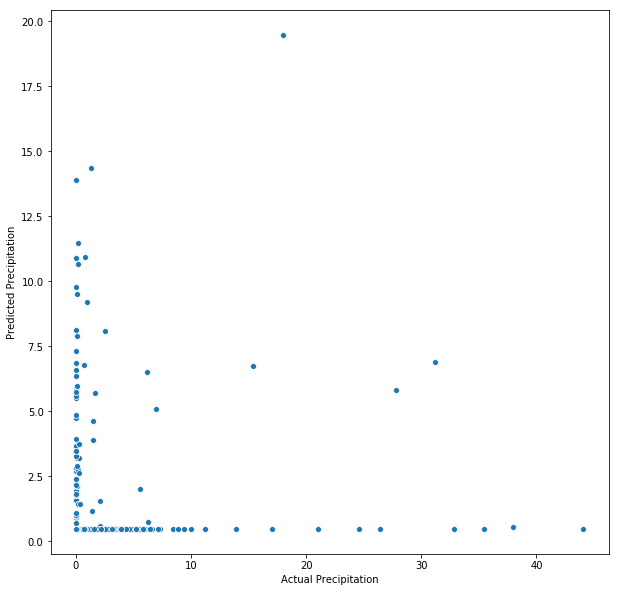

In [61]:
# 4. Test
if not classification:
    test_loss = model.evaluate([test_X_conv, test_X_scalar], test_y, verbose=0)
    print(f'Test loss= {test_loss:.4f}')

    test_y_hat = model.predict([test_X_conv, test_X_scalar])
    inverse_standardize(test_y, test_y_hat, scaler_y)

## Classification

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [30]:
if classification:
    proba_binary_hat = model.predict([test_X_conv, test_X_scalar])
    test_binary_hat = proba_binary_hat >= 0.5

In [31]:
if classification:
    print(accuracy_score(test_binary, test_binary_hat))
    print(classification_report(test_binary, test_binary_hat))
    print(confusion_matrix(test_binary, test_binary_hat))

0.6106442577030813
             precision    recall  f1-score   support

      False       0.61      0.70      0.65       736
       True       0.62      0.52      0.56       692

avg / total       0.61      0.61      0.61      1428

[[514 222]
 [334 358]]


In [32]:
score, acc = model.evaluate([test_X_conv, test_X_scalar], test_binary)
print('Test score:', score)
print('Test accuracy:', acc)

1428/1428 [==============================] - 0s 93us/step
Test score: 0.7617888292010758
Test accuracy: 0.6106442580370008


# Script Conversion (for ssh Burn)

In [25]:
!jupyter nbconvert --to script neural-net.ipynb

[NbConvertApp] Converting notebook neural-net.ipynb to script
[NbConvertApp] Writing 7226 bytes to neural-net.py
